In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from data import FloodEventDataset
from data.boundary_condition import BoundaryCondition
from data.dataset_normalizer import DatasetNormalizer
from utils import file_utils, metric_utils

### Training Stats

In [2]:
# training_stats_paths = [
#     'training_stats/GAT_2025-06-09_08-35-30_train_stats.npz',
#     'training_stats/GAT_2025-06-09_10-01-51_train_stats_w_edge.npz',
#     'training_stats/GCN_2025-06-09_10-59-33_train_stats.npz',
# ]
# training_stats_paths = [
#     'training_stats/GAT_2025-06-09_17-30-34_train_stats_phys_global.npz',
#     'training_stats/GCN_2025-06-09_22-38-50_train_stats_phys_global.npz',
# ]
# training_stats_paths = [
#     'training_stats/GAT_2025-06-09_08-35-30_train_stats.npz',
#     'training_stats/GCN_2025-06-09_10-59-33_train_stats.npz',
#     'training_stats/GAT_2025-06-09_17-30-34_train_stats_phys_global.npz',
#     'training_stats/GCN_2025-06-09_22-38-50_train_stats_phys_global.npz',
# ]
training_stats_paths = [
    'training_stats/06-23/GAT_2025-06-22_22-32-37_train_stats.npz',
    'training_stats/06-23/GCN_2025-06-23_00-55-58_train_stats.npz',
    'training_stats/06-23/GAT_2025-06-23_16-12-59_train_stats_w_global.npz',
    'training_stats/06-23/GCN_2025-06-24_01-24-17_train_stats_w_global.npz',
]

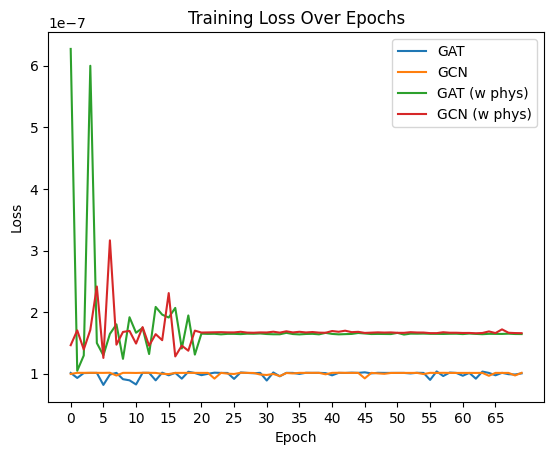

In [3]:
def plot_training_loss_for_all_models(stats_paths: list[str], start_epoch: int = 0, labels = None):
    for i, path in enumerate(stats_paths):
        label = labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        train_loss = np.load(path, allow_pickle=True)['train_epoch_loss']
        train_loss = train_loss[start_epoch:]
        plt.plot(train_loss, label=label)

    plt.title('Training Loss Over Epochs')
    plt.xticks(np.arange(len(train_loss), step=5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# labels = None
labels = ['GAT', 'GCN', 'GAT (w phys)', 'GCN (w phys)']
start_epoch = 30
plot_training_loss_for_all_models(training_stats_paths, start_epoch=start_epoch, labels=labels)

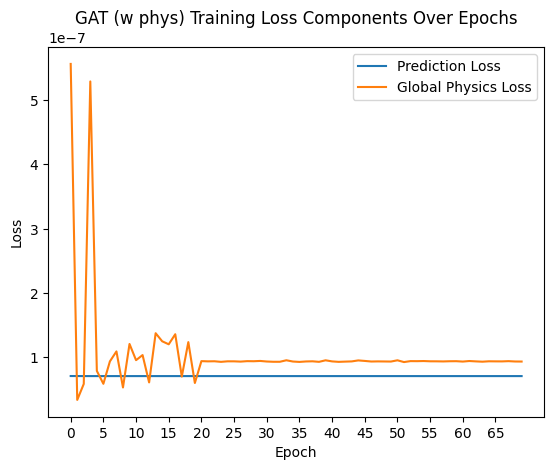

In [4]:
def plot_individual_training_loss(path: str, start_epoch: int = 0, model_label: str = None):
    loss_components = ['prediction_loss', 'global_physics_loss']
    for component in loss_components:
        train_loss = np.load(path, allow_pickle=True)[component]
        train_loss = train_loss[start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_loss, label=label)

    plt.title(f'{model_label if model_label is not None else ''} Training Loss Components Over Epochs')
    plt.xticks(np.arange(len(train_loss), step=5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# labels = None
PATH_IDX = 2
label = labels[PATH_IDX] if labels is not None else None
plot_individual_training_loss(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label)

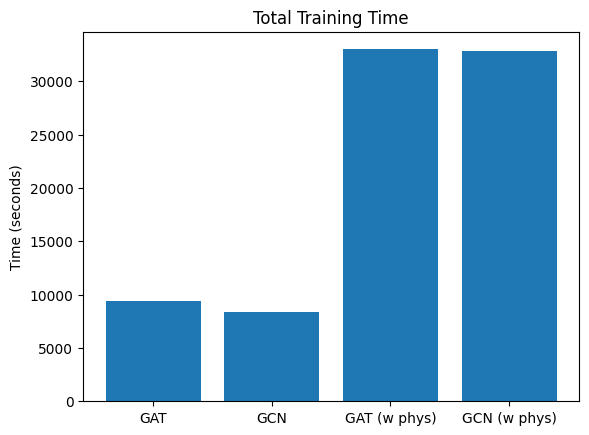

In [5]:
def plot_training_time_for_all_models(stats_paths: list[str], labels = None):
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in stats_paths]
    assert len(stats_paths) == len(labels), "Number of labels must match number of stats paths."

    all_train_time = []
    for path in stats_paths:
        train_time = np.load(path, allow_pickle=True)['train_time']
        all_train_time.append(train_time.item())

    plt.bar(labels, all_train_time)
    plt.title('Total Training Time')
    plt.ylabel('Time (seconds)')
    plt.show()

# labels = None
plot_training_time_for_all_models(training_stats_paths, labels=labels)

### Overall Metric Comparison

In [6]:
RUN_ID = 13 # 13, 14, 15, 16

# Rollout start: timestep 0
# metric_paths = [
#     f'saved_metrics/0611_rollout_start_0/GAT_2025-06-09_08-35-30_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/0611_rollout_start_0/GCN_2025-06-09_10-59-33_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/0611_rollout_start_0/GAT_2025-06-09_17-30-34_phys_global_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/0611_rollout_start_0/GCN_2025-06-09_22-38-50_phys_global_runid_{RUN_ID}_test_metrics.npz',
# ]

# Rollout start: timestep 10000
# metric_paths = [
#     f'saved_metrics/0611_rollout_start_10000/GAT_2025-06-09_08-35-30_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/0611_rollout_start_10000/GCN_2025-06-09_10-59-33_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/0611_rollout_start_10000/GAT_2025-06-09_17-30-34_phys_global_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/0611_rollout_start_10000/GCN_2025-06-09_22-38-50_phys_global_runid_{RUN_ID}_test_metrics.npz',
# ]

metric_paths = [
    f'saved_metrics/06-23/GAT_2025-06-22_22-32-37_runid_{RUN_ID}_test_metrics.npz',
    f'saved_metrics/06-23/GCN_2025-06-23_00-55-58_runid_{RUN_ID}_test_metrics.npz',
    f'saved_metrics/06-23/GAT_2025-06-23_16-12-59_w_global_runid_{RUN_ID}_test_metrics.npz',
    f'saved_metrics/06-23/GCN_2025-06-24_01-24-17_w_global_runid_{RUN_ID}_test_metrics.npz',
]

In [7]:
# Double check targets are the same
EPS = 1e-5
comparison_target = None
for path in metric_paths:
    print('Checking target for', path)
    target = np.load(path, allow_pickle=True)['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

Checking target for saved_metrics/06-23/GAT_2025-06-22_22-32-37_runid_13_test_metrics.npz
Checking target for saved_metrics/06-23/GCN_2025-06-23_00-55-58_runid_13_test_metrics.npz
Checking target for saved_metrics/06-23/GAT_2025-06-23_16-12-59_w_global_runid_13_test_metrics.npz
Checking target for saved_metrics/06-23/GCN_2025-06-24_01-24-17_w_global_runid_13_test_metrics.npz


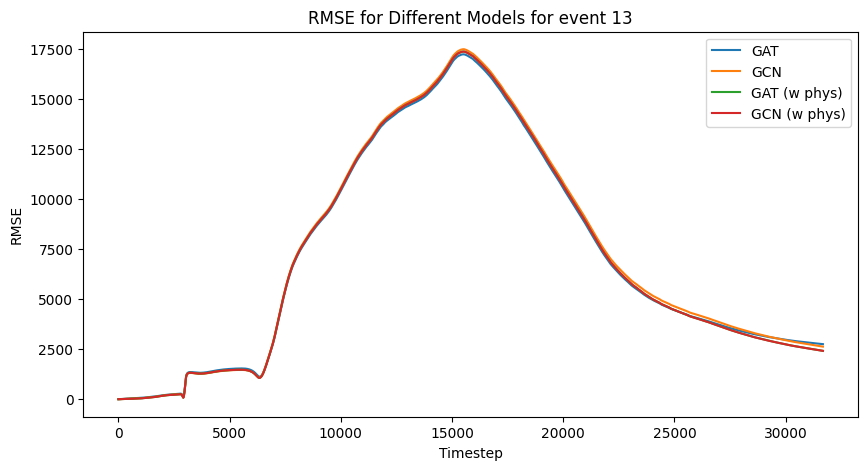

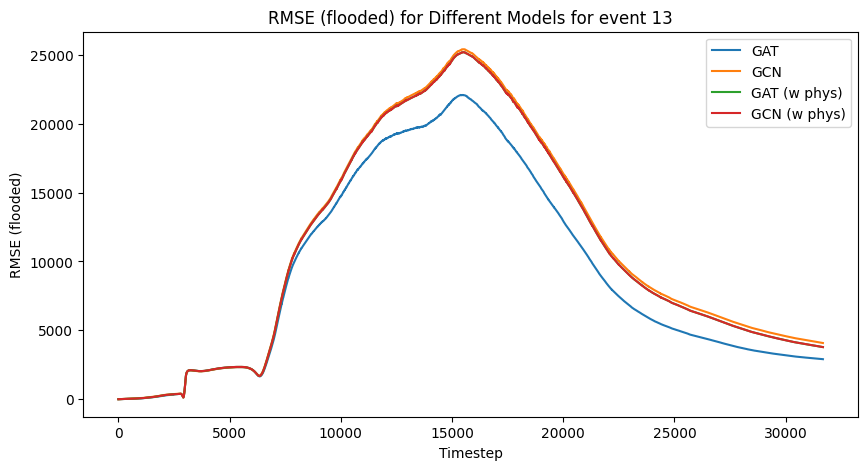

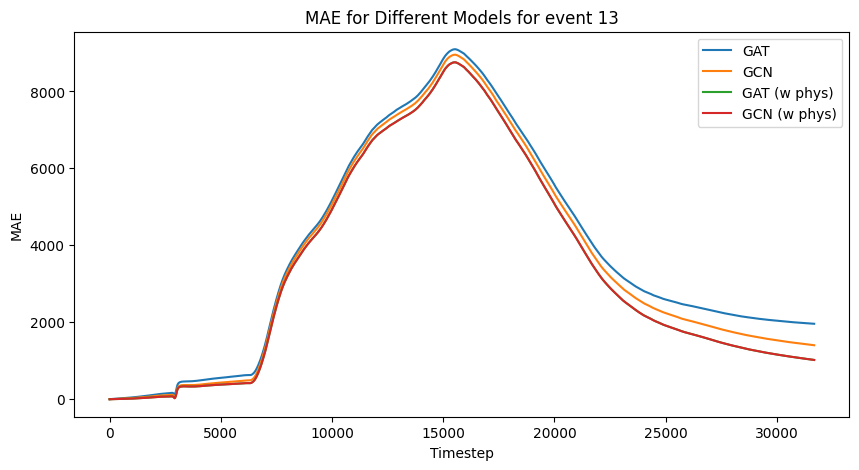

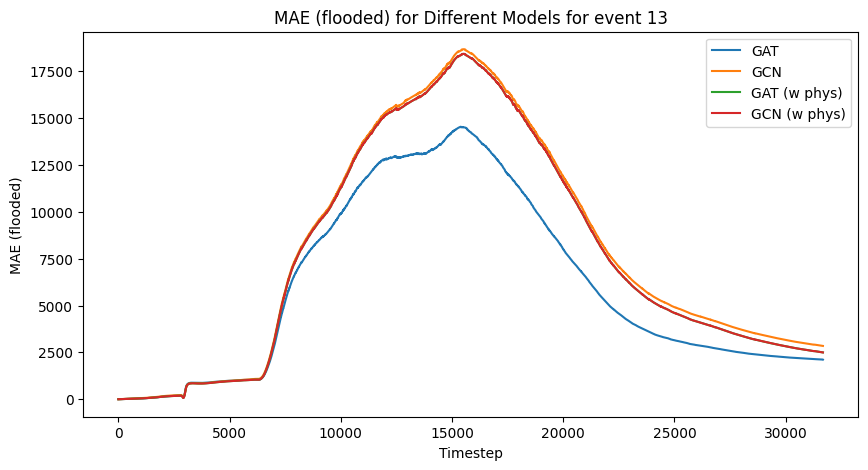

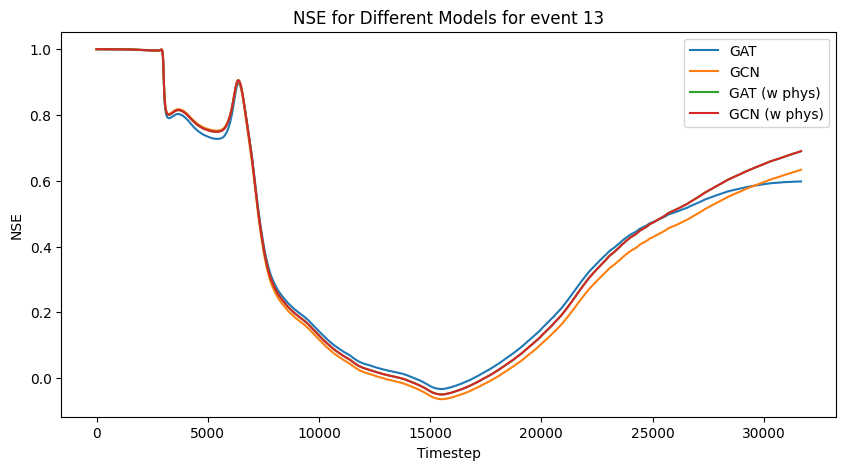

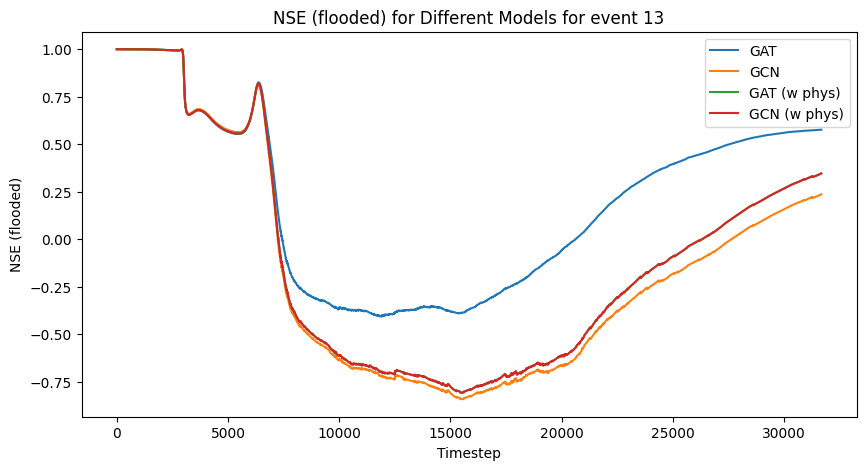

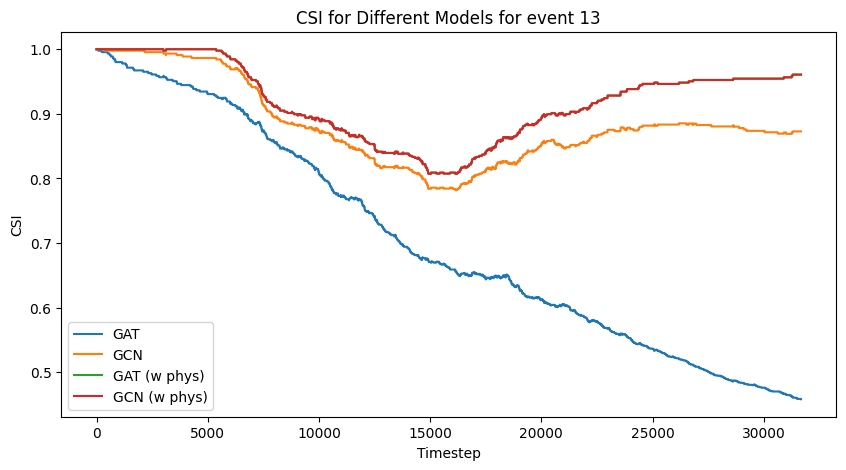

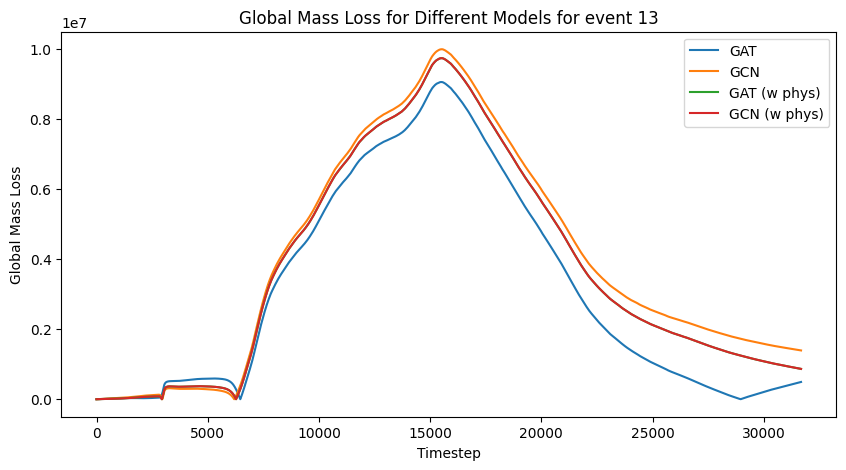

In [8]:
def plot_metric_for_all_models(metric_paths: list[str], metric: str, metric_name: str = None, labels: list[str] = None):
    split_metric = metric.split('_') 
    if metric_name is None:
        metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'{metric_name} for Different Models for event {event_name}')
    plt.xlabel('Timestep')
    plt.ylabel(metric_name)

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)[metric]
        # print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        if len(path.split('/')[-1].split('_')) == 4:
            label = f'{label} ({path.split('/')[-1].split('_')[3]})'

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(data, label=label)

    plt.legend()
    plt.show()

# labels=None
# labels = ['GAT (w phys)', 'GCN (w phys)']
labels = ['GAT', 'GCN', 'GAT (w phys)', 'GCN (w phys)']
metrics = ['rmse', 'rmse_flooded', 'mae', 'mae_flooded', 'nse', 'nse_flooded', 'csi', 'global_mass_loss']
metric_names = ['RMSE', 'RMSE (flooded)', 'MAE', 'MAE (flooded)', 'NSE', 'NSE (flooded)', 'CSI', 'Global Mass Loss']
for metric, metric_name in zip(metrics, metric_names):
    plot_metric_for_all_models(metric_paths, metric, metric_name=metric_name, labels=labels)

### Node Analysis

(Run ID 13) Peak water depth for node 500: 47667.97265625 (timestep 15543)


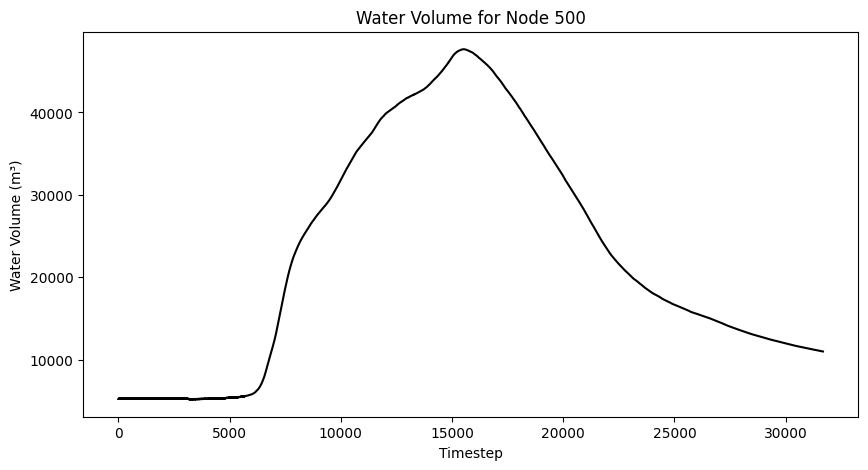

(Run ID 13) Peak water depth for node 1023: 18240.380859375 (timestep 15544)


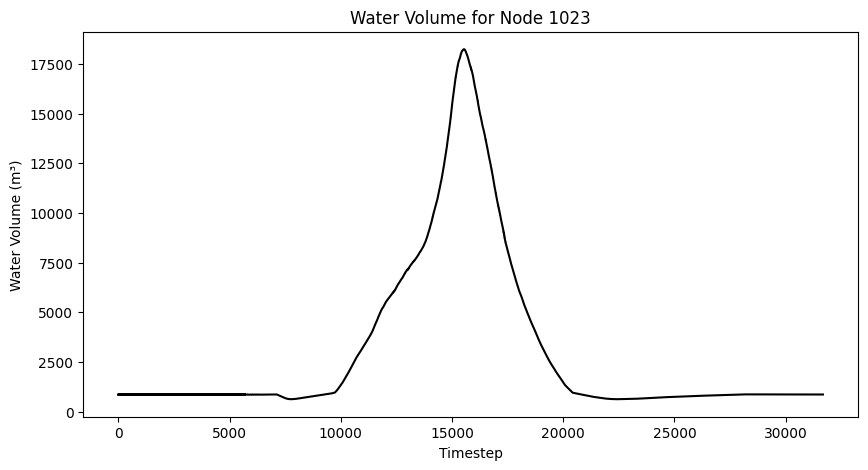

(Run ID 13) Peak water depth for node 576: 67177.7578125 (timestep 15359)


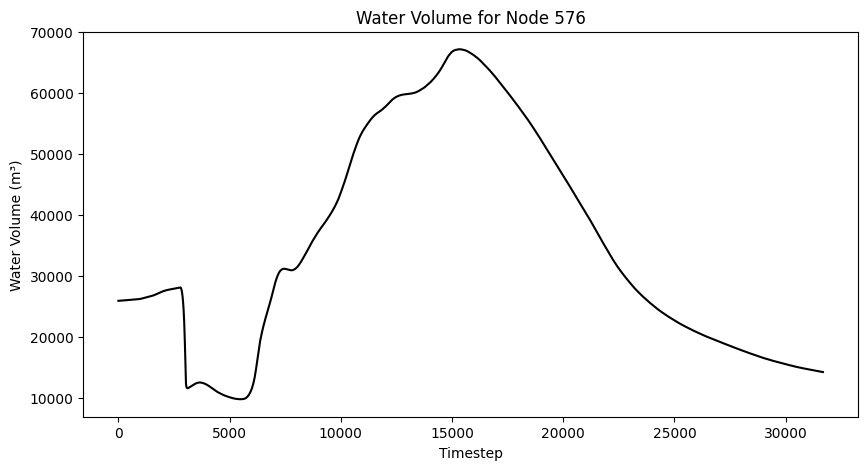

(Run ID 13) Peak water depth for node 782: 14837.634765625 (timestep 15543)


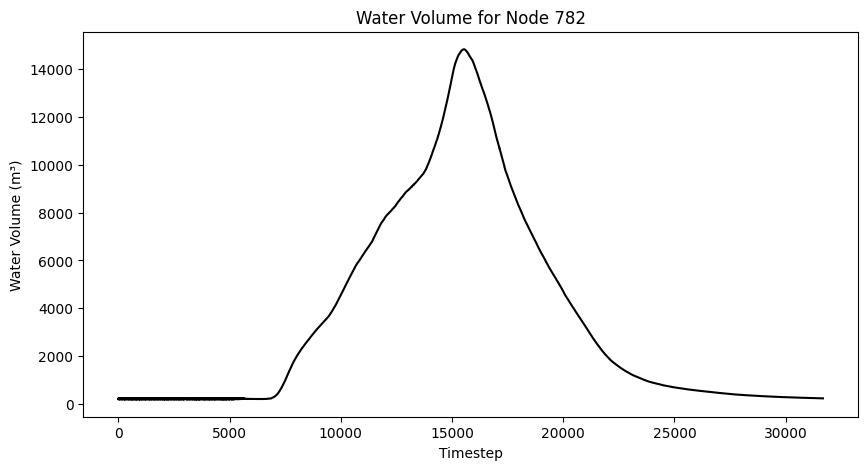

In [9]:
# Top 4 highest water differences
NODE_IDX_MAP = {
    13: [500, 1023, 576, 782], # Run ID 13
    14: [576, 443, 1026, 459], # Run ID 14
    15: [1022, 1026, 1023, 1082], # Run ID 15
    16: [1022, 1023, 1026, 1082], # Run ID 16
}
node_idxs = NODE_IDX_MAP[RUN_ID]

def plot_water_volume_for_node(node_idx: int, water_volume: np.ndarray, num_timesteps: int = None):
    if num_timesteps is None:
        num_timesteps = water_volume.shape[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')
    plt.plot(water_volume[:num_timesteps, node_idx], color='black')
    plt.show()

ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']

for node_idx in node_idxs:
    peak_wv = ground_truth[:, node_idx].max()
    peak_wv_timestep = ground_truth[:, node_idx].argmax()
    print(f"(Run ID {RUN_ID}) Peak water depth for node {node_idx}: {peak_wv} (timestep {peak_wv_timestep})")

    plot_water_volume_for_node(node_idx, ground_truth)

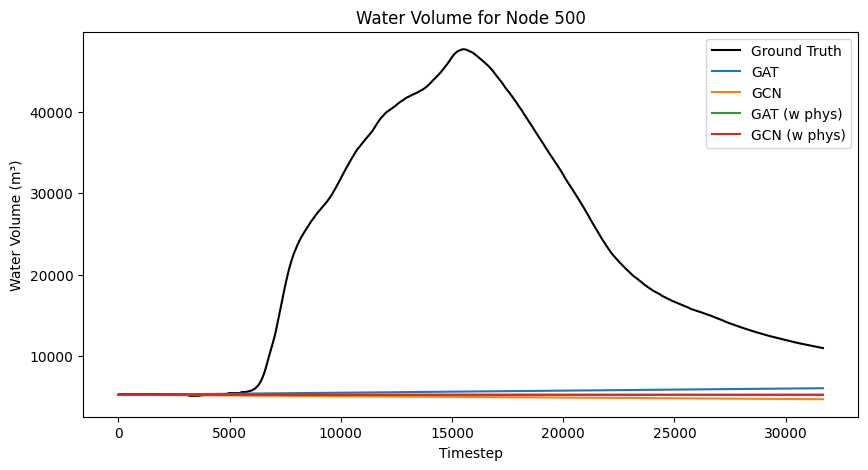

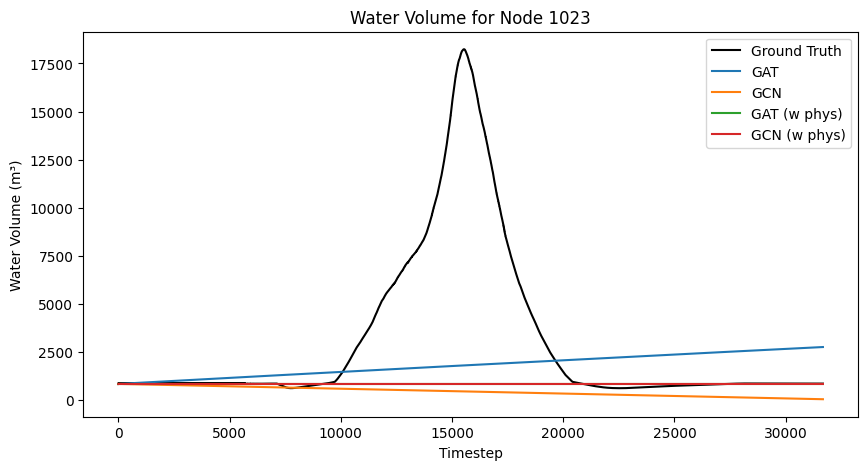

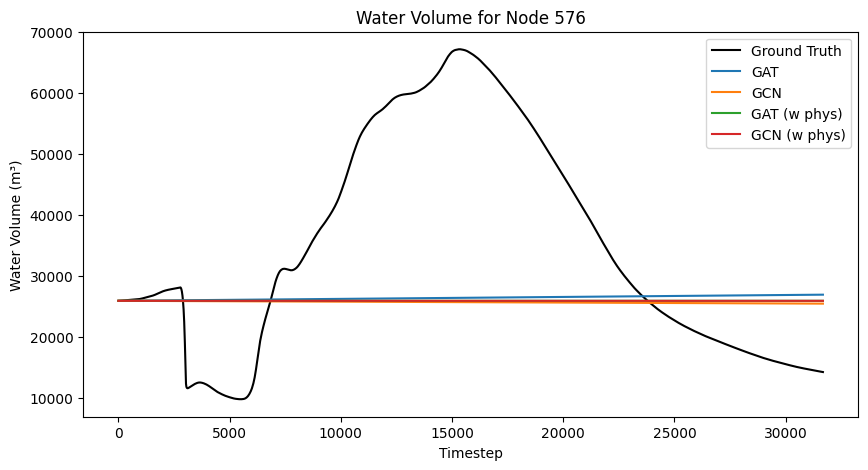

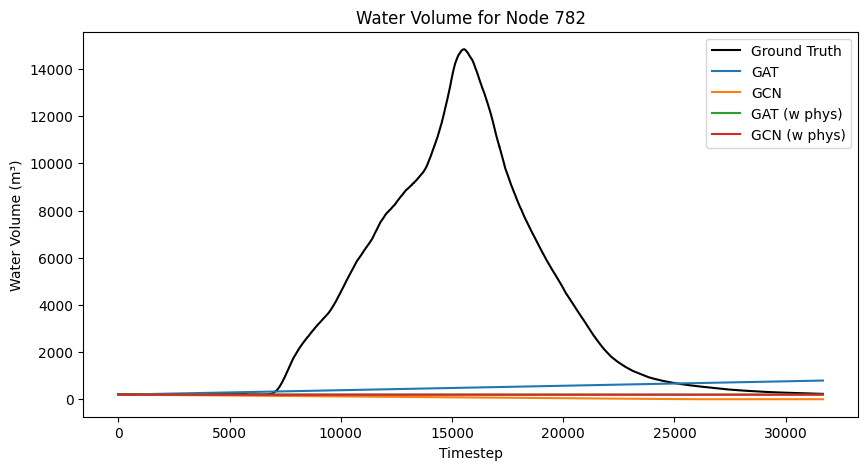

In [10]:
def plot_node_water_depth_for_all_models(metric_paths: list[str], node_idx: int, ground_truth: np.ndarray = None, labels: list[str] = None):
    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')

    if ground_truth is not None:
        plt.plot(ground_truth[:, node_idx], label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {path}: {pred.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(pred[:, node_idx], label=label)

    plt.legend()
    plt.show()

for node_idx in node_idxs:
    plot_node_water_depth_for_all_models(metric_paths, node_idx, ground_truth=ground_truth, labels=labels)

In [11]:
for node in node_idxs:
    print(f'Calculating NSE for node {node}...')
    node_gt = torch.Tensor(ground_truth[:, node])
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']
        node_pred = torch.Tensor(pred[:, node])
        nse = metric_utils.NSE(node_pred, node_gt)
        label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        print(f'\tNSE for {label}: {nse:.4f}')

Calculating NSE for node 500...
	NSE for GAT: -1.4864
	NSE for GCN: -1.6109
	NSE for GAT (w phys): -1.5604
	NSE for GCN (w phys): -1.5604
Calculating NSE for node 1023...
	NSE for GAT: -0.1077
	NSE for GCN: -0.3691
	NSE for GAT (w phys): -0.2670
	NSE for GCN (w phys): -0.2670
Calculating NSE for node 576...
	NSE for GAT: -0.2215
	NSE for GCN: -0.2557
	NSE for GAT (w phys): -0.2448
	NSE for GCN (w phys): -0.2447
Calculating NSE for node 782...
	NSE for GAT: -0.5248
	NSE for GCN: -0.6699
	NSE for GAT (w phys): -0.6262
	NSE for GCN (w phys): -0.6262


### Flood Map Analysis

In [12]:
def get_max_flood_map(metric_path: str, property: str) -> np.ndarray:
    per_cell_volume = np.load(metric_path, allow_pickle=True)[property]
    max_flood_map = per_cell_volume.max(axis=0)
    return max_flood_map

def get_node_df(config: dict, run_id: int, no_ghost: bool = True) -> gpd.GeoDataFrame:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']
    nodes_shp_file = dataset_parameters['nodes_shp_file']
    nodes_shp_path = os.path.join(root_dir, 'raw', nodes_shp_file)
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
        dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
        summary_df = pd.read_csv(dataset_summary_path)
        summary_df = summary_df[summary_df['Run_ID'] == run_id]
        hec_ras_file = summary_df['HECRAS_Filepath'].values[0]
        hec_ras_path = os.path.join(root_dir, 'raw', hec_ras_file)

        inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
        outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

        bc = BoundaryCondition(hec_ras_path=hec_ras_path,
                               inflow_boundary_nodes=inflow_boundary_nodes,
                               outflow_boundary_nodes=outflow_boundary_nodes)
        node_df = node_df[~node_df['CC_index'].isin(bc.ghost_nodes)]

    return node_df

def get_volume_theshold_per_cell(config: dict, constant_values_path: str, percent_of_area: float = 0.05) -> np.ndarray:
    dataset_parameters = config['dataset_parameters']

    # Get area
    constant_values = np.load(constant_values_path)
    static_nodes = constant_values['static_nodes']
    static_nodes = np.load(constant_values_path)['static_nodes']
    area_idx = FloodEventDataset.STATIC_NODE_FEATURES.index('area')
    area = static_nodes[:, area_idx]

    # Denormalize
    if dataset_parameters['normalize']:
        root_dir = dataset_parameters['root_dir']
        features_stats_file = dataset_parameters['features_stats_file']
        normalizer = DatasetNormalizer(mode='test', root_dir=root_dir, features_stats_file=features_stats_file)
        area = normalizer.denormalize('area', area)

    # Filter out boundary nodes
    inflow_boundary_nodes = constant_values['inflow_boundary_nodes']
    outflow_boundary_nodes = constant_values['outflow_boundary_nodes']
    boundary_nodes = np.union1d(inflow_boundary_nodes, outflow_boundary_nodes)
    non_boundary_nodes = torch.ones(area.shape[0], dtype=torch.bool)
    non_boundary_nodes[boundary_nodes] = False
    area = area[non_boundary_nodes, None]

    # Get threshold
    threshold_per_cell = area * percent_of_area
    return threshold_per_cell

def convert_water_to_binary(water_depth: np.ndarray, water_threshold: np.ndarray) -> np.ndarray:
    is_flooded_int = (water_depth > water_threshold).astype(int).squeeze()
    is_flooded_str = pd.cut(is_flooded_int, bins=[-1, 0, 1], labels=['Not Flooded', 'Flooded'])
    return is_flooded_str

def plot_cell_map(axis, node_df: gpd.GeoDataFrame, value: np.ndarray, title: str, legend_kwds: dict = None):
    value_column = 'is_flooded'
    cmap = plt.get_cmap('seismic_r') 
    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        'linewidth': 0.3,
        'markersize': 3,
        'legend': True,
        'legend_kwds': legend_kwds,
    }
    node_df[value_column] = value

    node_df.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

def plot_max_flood_map_for_all_models(metric_paths: list[str],
                                      node_df: gpd.GeoDataFrame,
                                      ground_truth: np.ndarray = None,
                                      labels: list[str] = None,
                                      water_threshold: np.ndarray = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    with_threshold = water_threshold is not None
    legend_kwds = { 'loc': 'lower right', 'fontsize': 'x-small' } if with_threshold else None

    fig, ax = plt.subplots(figsize=(12,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max flood maps for event {event_name}')
    index = 0

    if ground_truth is not None:
        ax_row = index // ncols
        ax_col = index % ncols
        axis = ax[ax_row, ax_col]

        if with_threshold:
            ground_truth = convert_water_to_binary(ground_truth, water_threshold)

        plot_cell_map(axis, node_df, ground_truth, title='Ground Truth', legend_kwds=legend_kwds)
        index += 1

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = get_max_flood_map(path, 'pred')
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        ax_row = index // ncols
        ax_col = index % ncols
        axis = ax[ax_row, ax_col]

        if with_threshold:
            pred = convert_water_to_binary(pred, water_threshold)

        title = path.split('/')[-1].split('_')[0]
        if labels is not None:
            title = labels[i] if i < len(labels) else title

        plot_cell_map(axis, node_df, pred, title=title, legend_kwds=legend_kwds)
        index += 1

    while index < (nrows * ncols):
        ax_row = index // ncols
        ax_col = index % ncols
        ax[ax_row, ax_col].axis('off')
        index += 1

    plt.show()

In [13]:
ground_truth = get_max_flood_map(metric_paths[0], 'target')

print(f'Calculating RMSE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    rmse = metric_utils.RMSE(pred_max_flood_map, torch.Tensor(ground_truth))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tRMSE for {label}: {rmse:.4f}')

print(f'Calculating MAE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    mae = metric_utils.MAE(pred_max_flood_map, torch.Tensor(ground_truth))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tMAE for {label}: {mae:.4f}')

Calculating RMSE for max flood maps...
	RMSE for GAT: 17095.8262
	RMSE for GCN: 17349.2500
	RMSE for GAT (w phys): 17349.4316
	RMSE for GCN (w phys): 17349.4336
Calculating MAE for max flood maps...
	MAE for GAT: 9397.6523
	MAE for GCN: 8757.2930
	MAE for GAT (w phys): 8757.2676
	MAE for GCN (w phys): 8757.2686


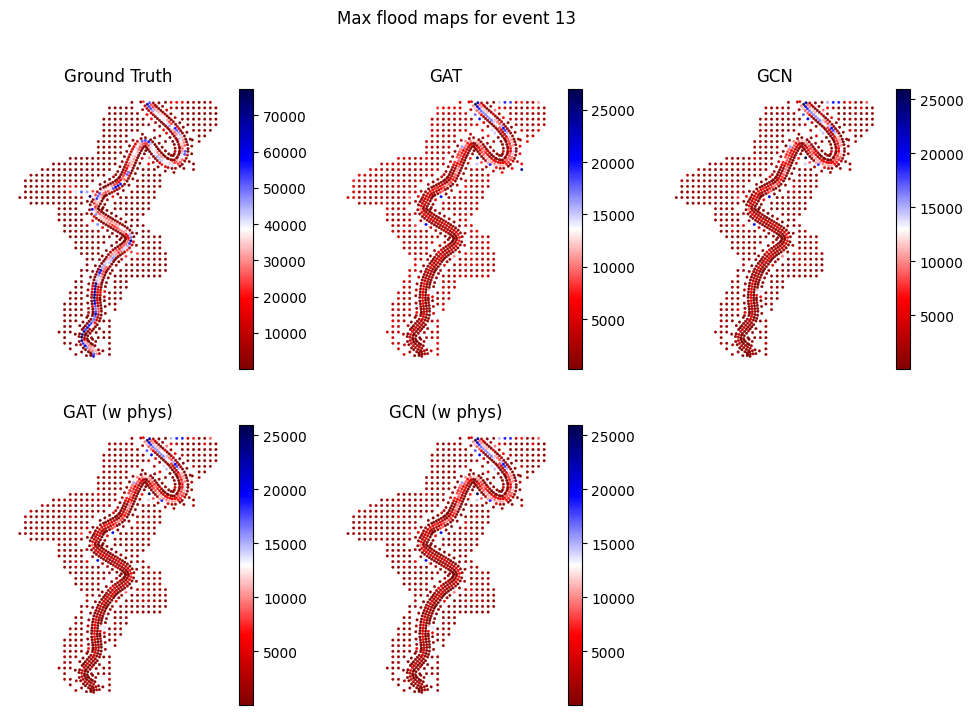

In [14]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

node_df = get_node_df(config, RUN_ID, no_ghost=True)
plot_max_flood_map_for_all_models(metric_paths, node_df, labels=labels, ground_truth=ground_truth, water_threshold=None)

In [15]:
PERCENT_OF_AREA = 0.05
constant_values_path = 'data/datasets/processed/constant_values.npz'

water_threshold = get_volume_theshold_per_cell(config, constant_values_path, percent_of_area=PERCENT_OF_AREA)
binary_gt_max_map = torch.Tensor((ground_truth > water_threshold)).to(torch.bool)
print(f'Ground truth num flooded cells: {binary_gt_max_map.sum().item()}')
print(f'Calculating CSI (threshold = ({PERCENT_OF_AREA})) for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = get_max_flood_map(path, 'pred')
    binary_pred_max_map = torch.Tensor((pred_max_flood_map > water_threshold)).to(torch.bool)
    csi = metric_utils.CSI(binary_pred_max_map, binary_gt_max_map)
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tCSI for {label}: {csi:.4f} (Num flooded cells: {binary_pred_max_map.sum().item()})')

Ground truth num flooded cells: 542
Calculating CSI (threshold = (0.05)) for max flood maps...
	CSI for GAT: 0.5054 (Num flooded cells: 992)
	CSI for GCN: 0.8155 (Num flooded cells: 442)
	CSI for GAT (w phys): 0.8155 (Num flooded cells: 442)
	CSI for GCN (w phys): 0.8155 (Num flooded cells: 442)


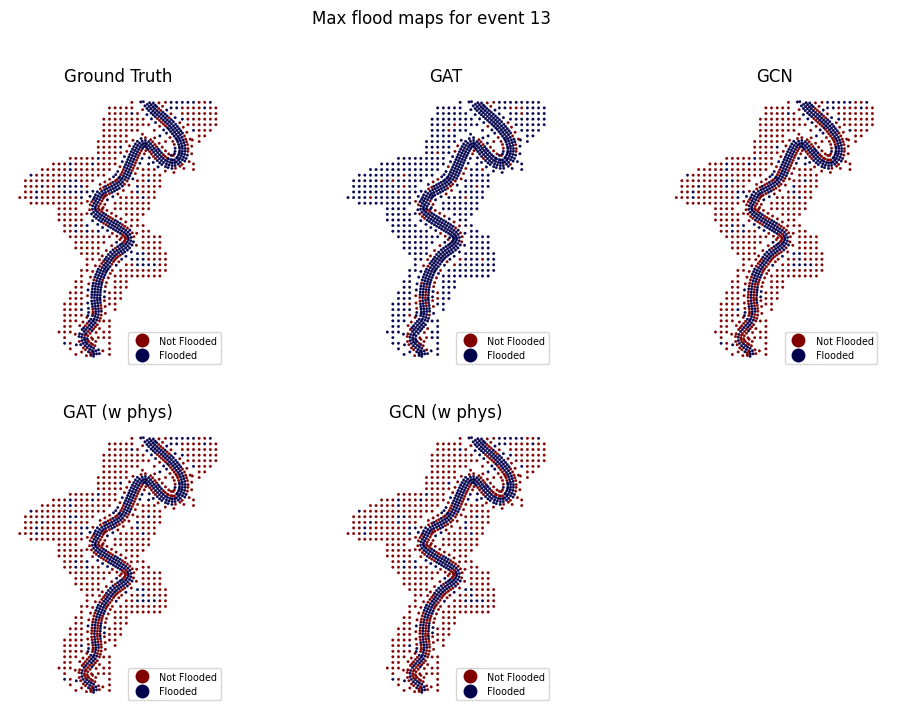

In [16]:
plot_max_flood_map_for_all_models(metric_paths, node_df, labels=labels, ground_truth=ground_truth, water_threshold=water_threshold)